In [5]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

ox.config(use_cache=True, log_console=True)
ox.__version__

'0.11.4'

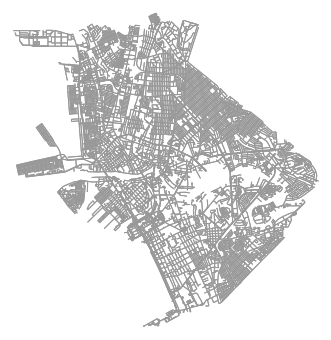

In [3]:
# get a graph for some city
G = ox.graph_from_place('Manila, Philippines', network_type='walk',)
fig, ax = ox.plot_graph(G, node_size = 0)

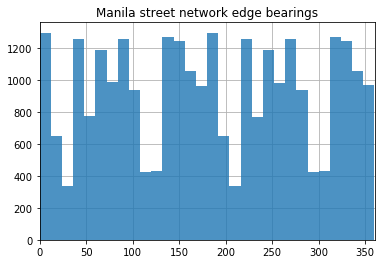

In [8]:
# calculate edge bearings and visualize their frequency
G = ox.add_edge_bearings(G)
bearings = pd.Series([data['bearing'] for u, v, k, data in G.edges(keys=True, data=True)])
ax = bearings.hist(bins=30, zorder=2, alpha=0.8)
xlim = ax.set_xlim(0, 360)
ax.set_title('Manila street network edge bearings')
plt.show()

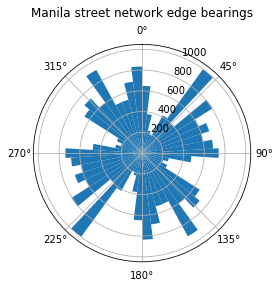

In [10]:
# polar plot
import numpy as np
n = 50
count, division = np.histogram(bearings, bins=[ang*360/n for ang in range(0,n+1)])
division = division[0:-1]
width =  2 * np.pi/n
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction('clockwise')
bars = ax.bar(division * np.pi/180 - width * 0.5 , count, width=width, bottom=0.0)
ax.set_title('Manila street network edge bearings', y=1.1)
plt.show()

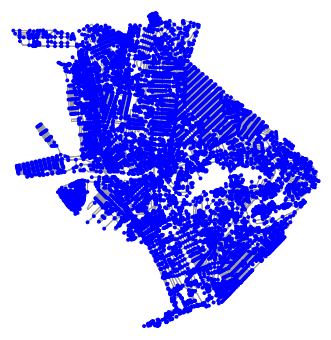

In [16]:
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3)

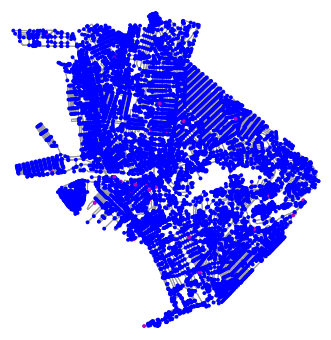

In [18]:
loops = [edge[0] for edge in nx.selfloop_edges(G)]
nc = ['m' if node in loops else 'b' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

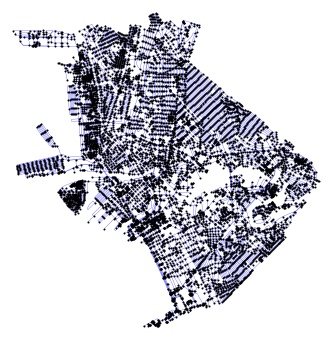

In [21]:
# highlight one-way streets
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=1, node_zorder=3, 
                           edge_color=ec, edge_linewidth=0.25, edge_alpha=0.5)

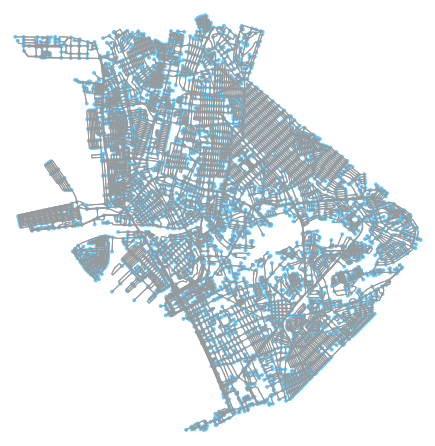

In [4]:
G_projected = ox.project_graph(G)
fig, ax = ox.plot_graph(G_projected, save=True, file_format='svg')

In [5]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

56566107.712543845

In [6]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 9306,
 'm': 28192,
 'k_avg': 6.058886739737804,
 'intersection_count': 8156,
 'streets_per_node_avg': 3.044272512357619,
 'streets_per_node_counts': {0: 0,
  1: 1150,
  2: 0,
  3: 5507,
  4: 2594,
  5: 47,
  6: 8},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.12357618740597465,
  2: 0.0,
  3: 0.5917687513432194,
  4: 0.27874489576617234,
  5: 0.005050505050505051,
  6: 0.0008596604341285192},
 'edge_length_total': 2007600.8320000062,
 'edge_length_avg': 71.2117207718504,
 'street_length_total': 1010385.9680000009,
 'street_length_avg': 71.48114382737892,
 'street_segments_count': 14135,
 'node_density_km': 164.5154735993324,
 'intersection_density_km': 144.18527860263862,
 'edge_density_km': 35491.23164355198,
 'street_density_km': 17862.038044663663,
 'circuity_avg': 1.0473941487853358,
 'self_loop_proportion': 0.0027667423382519863,
 'clean_intersection_count': 4805,
 'clean_intersection_density_km': 84.94485822531615}

In [7]:
ox.save_graph_shapefile(G, filename='mynetwork_shapefile')
ox.save_graphml(G, filename='mynetwork.graphml')

In [8]:
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

In [9]:
# get the nearest network node to each point
orig_node = ox.get_nearest_node(G, (14.601840, 120.973326))
dest_node = ox.get_nearest_node(G, (14.602052, 121.015432))

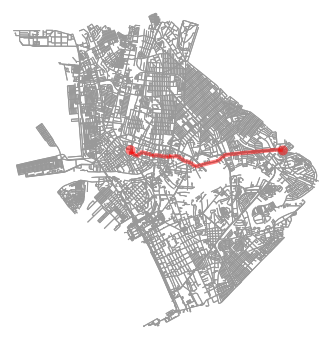

In [10]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [11]:
# how long is our route in meters?
nx.shortest_path_length(G, orig_node, dest_node, weight='length')

5046.901000000001

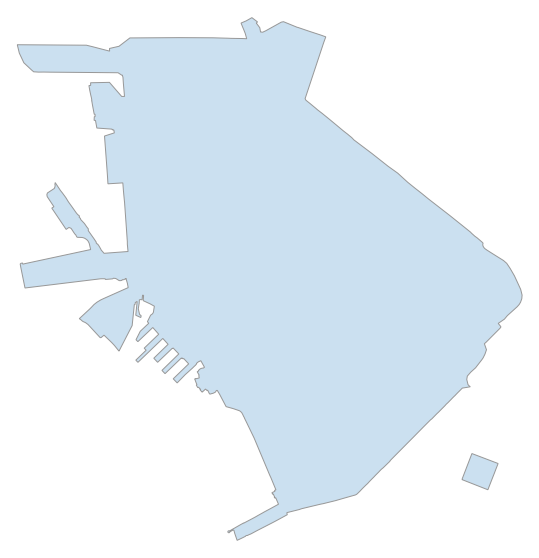

In [12]:
city = ox.gdf_from_place('Manila, Philippines')
ox.save_gdf_shapefile(city)
city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(10,10))

In [13]:
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)

In [16]:
#GeoJSON of Rail Routes in Manila (there is one)
url = 'https://transit.land/api/v1/routes.geojson?operated_by=o-wdw4-philippinenationalrailways&per_page=false'

with open('routes.geojson', 'wb') as f:
    r = requests.get(url)
    f.write(r.content)

In [17]:
mnlroutes = gpd.read_file('routes.geojson')

In [18]:
mnlroutes.head()

,id,onestop_id,created_at,updated_at,tags,created_or_updated_in_changeset_id,name,vehicle_type,color,stops_served_by_route,operated_by_onestop_id,operated_by_name,wheelchair_accessible,bikes_allowed,title,geometry
0,r-wdw4-pnrmc,r-wdw4-pnrmc,2017-03-13T17:49:14,2017-05-16T21:01:44,{'route_url': 'http://www.pnr.gov.ph/metro_com...,5976,PNR MC,rail,E58E11,"[ { ""stop_onestop_id"": ""s-wdw50gcvjb-tutubanpn...",o-wdw4-philippinenationalrailways,Philippine National Railways,unknown,unknown,r-wdw4-pnrmc,"MULTILINESTRING ((120.97323 14.61161, 120.9737..."


In [19]:
#GeoJSON of rail stops in Manila (There are 34)
url = 'https://transit.land/api/v1/stops.geojson?served_by=o-wdw4-philippinenationalrailways&per_page=false'

with open('stops.geojson', 'wb') as f:
    r = requests.get(url)
    f.write(r.content)

In [20]:
stops = gpd.read_file('stops.geojson')

In [26]:
stops.tail()

,id,onestop_id,created_at,updated_at,tags,created_or_updated_in_changeset_id,name,timezone,osm_way_id,parent_stop_onestop_id,wheelchair_boarding,geometry_reversegeo,geometry_centroid,operators_serving_stop,routes_serving_stop,title,geometry
29,s-wdw46mqu3d-bicutanpnr,s-wdw46mqu3d-bicutanpnr,2017-03-17T13:48:04,2020-03-10T23:05:05,"{'osm_way_id': '621415088', 'wheelchair_boardi...",5976,Bicutan PNR,Asia/Manila,621415088,None,None,None,"{'type': 'Point', 'coordinates': [121.04571104...","[ { ""operator_name"": ""Philippine National Rail...","[ { ""operator_name"": ""Philippine National Rail...",s-wdw46mqu3d-bicutanpnr,POINT (121.04571 14.48759)
30,s-wdw44wfx5r-sucatpnr,s-wdw44wfx5r-sucatpnr,2017-03-17T13:48:06,2020-03-04T21:55:06,"{'osm_way_id': '27259075', 'wheelchair_boardin...",5976,Sucat PNR,Asia/Manila,27259075,None,None,None,"{'type': 'Point', 'coordinates': [121.05093598...","[ { ""operator_name"": ""Philippine National Rail...","[ { ""operator_name"": ""Philippine National Rail...",s-wdw44wfx5r-sucatpnr,POINT (121.05094 14.45238)
31,s-wdw44880pv-alabangpnr,s-wdw44880pv-alabangpnr,2017-03-17T13:48:07,2020-03-04T03:22:01,"{'osm_way_id': '122345440', 'wheelchair_boardi...",5976,Alabang PNR,Asia/Manila,122345440,None,None,None,"{'type': 'Point', 'coordinates': [121.04769587...","[ { ""operator_name"": ""Philippine National Rail...","[ { ""operator_name"": ""Philippine National Rail...",s-wdw44880pv-alabangpnr,POINT (121.04770 14.41684)
32,s-wdw1fe2pmy-muntinlupapnr,s-wdw1fe2pmy-muntinlupapnr,2017-03-17T13:48:08,2020-03-11T01:33:04,"{'osm_way_id': '353501525', 'wheelchair_boardi...",5976,Muntinlupa PNR,Asia/Manila,353501525,None,None,None,"{'type': 'Point', 'coordinates': [121.04761004...","[ { ""operator_name"": ""Philippine National Rail...","[ { ""operator_name"": ""Philippine National Rail...",s-wdw1fe2pmy-muntinlupapnr,POINT (121.04761 14.38925)
33,s-wdw1dwuxwj-sanpedropnr,s-wdw1dwuxwj-sanpedropnr,2017-03-17T13:48:10,2020-03-04T22:20:04,"{'osm_way_id': '422608639', 'wheelchair_boardi...",5976,San Pedro PNR,Asia/Manila,422608639,None,None,None,"{'type': 'Point', 'coordinates': [121.05380058...","[ { ""operator_name"": ""Philippine National Rail...","[ { ""operator_name"": ""Philippine National Rail...",s-wdw1dwuxwj-sanpedropnr,POINT (121.05380 14.36457)


In [28]:
print(mnlroutes.crs)

epsg:4326
